In [161]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d'
run_name = 'helix5'
#source_dir = '../data/'+system_name+'/'+run_name+'/'
#data_dir = '../data/'+system_name+'/'+run_name+'_eval/'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

## Evaluate

In [162]:
# READING THE ENVIRONMENTAL PARAMETERS
env_params = ut.read_params(data_dir+'param_env.txt')
for ep in env_params:
    print(ep, env_params[ep])
alg_params = ut.read_params(data_dir+'param_alg.txt')
for ep in alg_params:
    print(ep, alg_params[ep])
#eps = ut.p_law_burn(alg_params['n_steps'], alg_params['eps_burn'], alg_params['eps_expn'], alg_params['eps0'], alg_params['epsc'])

int_steps 0.001
ep_length 200.0
ep_length_eval 600.0
decision_time 0.25
alphas [  6.   8.  10.  12.  14.  16.  18.  20.]
CL_alphas [ 0.65  0.75  0.82  0.9   1.    1.08  1.1   1.05]
CD_alphas [ 0.05  0.07  0.09  0.1   0.13  0.18  0.18  0.21]
init_theta 1.0471975511965976
init_dtheta 0.0
init_alpha 7.0
beta_bins [-1.57079633 -1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293
  0.52359878  0.87266463  1.22173048  1.57079633]
banks [-0.26179939 -0.20943951 -0.15707963 -0.10471976 -0.05235988  0.
  0.05235988  0.10471976  0.15707963  0.20943951  0.26179939]
init_bank 12.0
init_phi 0.0
init_dphi 0.0
wind_type const
v_wind_x 12.0
v_wind_y 0.0
v_wind_z 0.0
alg_type sarsa
gamma 1.0
n_steps 15000000.0
traj_points 1000.0
eval_steps 10000.0
lr0 0.1
lr1 0.01
n0 10000.0
lrc 100000.0
lr_expn 0.6
lr_burn0 7500000.0
lr_burn1 7500000.0
eps0 0.1
epsc 100000.0
eps_expn 0.6
eps_burn 7500000.0
init_quals 3000.0


In [163]:
s_traj, s_head = ut.read_traj(data_dir + 'ev_states.txt')

In [164]:
xs = np.linspace(0, alg_params['eval_steps']*env_params['decision_time'], int(alg_params['eval_steps']))

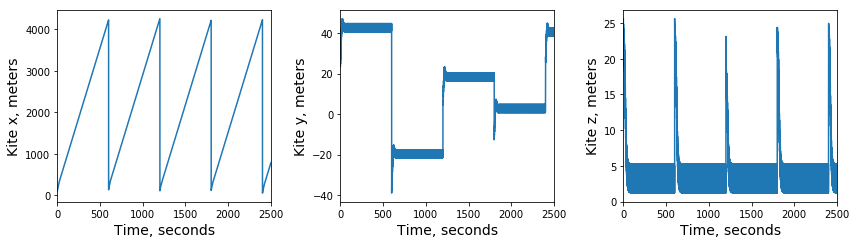

In [165]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))

lim = [0,2500]

ax1.set_xlim(lim)
#ax1.set_ylim(0,3000)
ax1.set_xlabel('Time, seconds', fontsize=14)
ax1.set_ylabel('Kite x, meters', fontsize=14)
ax1.plot(xs, s_traj[:,0])

ax2.set_xlim(lim)
ax2.set_xlabel('Time, seconds', fontsize=14)
ax2.set_ylabel('Kite y, meters', fontsize=14)
ax2.plot(xs, s_traj[:,1])

ax3.set_xlim(lim)
ax3.set_xlabel('Time, seconds', fontsize=14)
ax3.set_ylabel('Kite z, meters', fontsize=14)
ax3.plot(xs, s_traj[:,2])

plt.tight_layout()
plt.savefig(plot_dir+"eval_traj_true.png", dpi=200)
plt.show()

In [166]:
info_traj, labels = ut.read_traj(data_dir+'ev_info.txt')
info_i_traj = np.array(info_traj[:,0], dtype=int)
print(labels)

['state_index', 'state_descr', 'acion_index', 'action_decr', 'reward']


In [167]:
beta_list = []
for i in range(len(env_params['beta_bins'])-1):
    beta_list.append((env_params['beta_bins'][i] + env_params['beta_bins'][i+1])/2.0)

In [168]:
def aggr_state_index_translator(index, n_betas, n_banks):
    if system_name != "kite3d":
        beta = index % n_betas
        rest = index // n_betas
        bank = rest % n_banks
        alpha = rest // n_banks
    else:
        beta = index % n_betas
        bank = index % n_banks
        alpha = index // n_banks
    return beta, bank, alpha

In [169]:
beta_i, bank_i, alpha_i = aggr_state_index_translator(info_i_traj, len(env_params['beta_bins'])-1, len(env_params['banks']))
alphas = np.take(env_params['alphas'], alpha_i)
banks = np.take(env_params['banks'], bank_i)
betas = np.take(beta_list, beta_i)

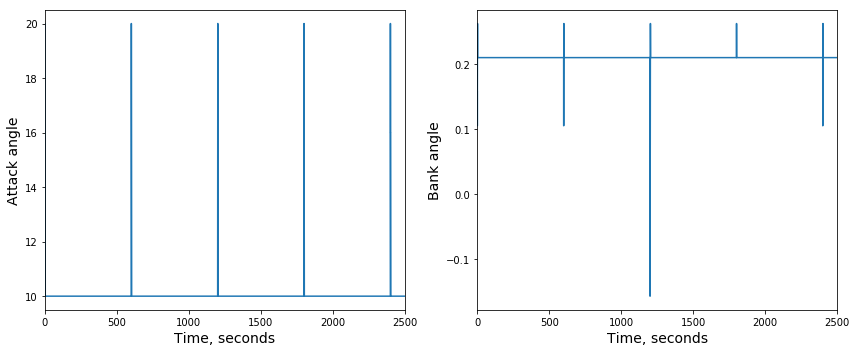

In [170]:
if system_name != "kite3d":
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))
else:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

x_wind = [0,2500]

ax1.set_xlabel('Time, seconds', fontsize=14)
ax1.set_ylabel('Attack angle', fontsize=14)
ax1.set_xlim(x_wind)
ax1.plot(xs, alphas)

ax2.set_xlabel('Time, seconds', fontsize=14)
ax2.set_ylabel('Bank angle', fontsize=14)
ax2.set_xlim(x_wind)
ax2.plot(xs, banks)

if system_name != "kite3d":
    ax3.set_xlabel('Time, seconds', fontsize=14)
    ax3.set_ylabel('Vrel angle', fontsize=14)
    ax3.set_xlim(x_wind)
    ax3.plot(xs, betas)

plt.tight_layout()
plt.savefig(plot_dir+"eval_pol.png", dpi=200)
plt.show()

In [171]:
def bins_from_list(l):
    bins = np.array([(l[i] + l[i+1])/2 for i in range(len(l)-1)])
    bins = np.append(2*l[0] - bins[0], bins)
    bins = np.append(bins, 2*l[-1] - bins[-1])
    return bins

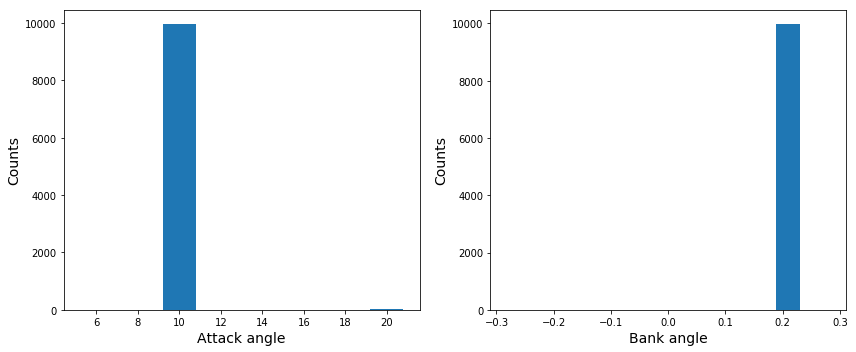

In [172]:
if system_name != "kite3d":
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))
else:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.set_ylabel('Counts', fontsize=14)
ax1.set_xlabel('Attack angle', fontsize=14)
bins = bins_from_list(env_params['alphas'])
ax1.set_xticks(env_params['alphas'])
ax1.hist(alphas, bins=bins, align='mid', rwidth=0.8)

ax2.set_ylabel('Counts', fontsize=14)
ax2.set_xlabel('Bank angle', fontsize=14)
bins = bins_from_list(env_params['banks'])
#ax2.set_xticks(env_params['banks'])
ax2.hist(banks, bins=bins, align='mid', rwidth=0.8)

if system_name != "kite3d":
    ax3.set_ylabel('Counts', fontsize=14)
    ax3.set_xlabel('Vrel angle', fontsize=14)
    bins = bins_from_list(beta_list)
    #ax2.set_xticks(env_params['banks'])
    ax3.hist(betas, bins=bins, align='mid', rwidth=0.8)

plt.tight_layout()
plt.savefig(plot_dir+"aggr_states.png", dpi=200)
plt.show()

In [173]:
return_s_traj, head = ut.read_traj(data_dir+'return_traj.txt')
return_i_steps = np.array(return_s_traj[:,1], dtype=int)

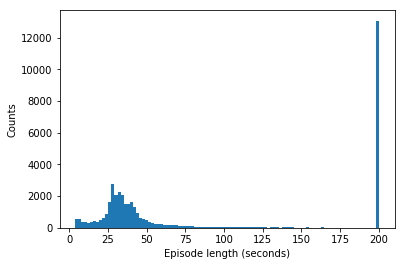

In [174]:
g=plt.hist(return_i_steps/4, bins = 100, density = False)
plt.xlabel('Episode length (seconds)')
plt.ylabel('Counts')
#plt.xlim(0,1000)
plt.savefig(plot_dir+"hist_endtimes.png", dpi=200)
plt.show()

In [175]:
print(g[0])

[  5.28000000e+02   5.76000000e+02   3.82000000e+02   3.68000000e+02
   3.29000000e+02   3.79000000e+02   4.11000000e+02   3.72000000e+02
   5.18000000e+02   6.03000000e+02   8.50000000e+02   1.60900000e+03
   2.74000000e+03   2.05900000e+03   2.25400000e+03   2.06200000e+03
   1.52400000e+03   1.52800000e+03   1.64300000e+03   1.33300000e+03
   9.15000000e+02   6.23000000e+02   5.58000000e+02   4.71000000e+02
   3.46000000e+02   3.12000000e+02   2.49000000e+02   2.39000000e+02
   2.22000000e+02   1.98000000e+02   1.75000000e+02   1.67000000e+02
   1.47000000e+02   1.52000000e+02   1.22000000e+02   1.10000000e+02
   1.08000000e+02   1.11000000e+02   8.40000000e+01   8.00000000e+01
   7.80000000e+01   6.00000000e+01   6.10000000e+01   7.90000000e+01
   5.80000000e+01   5.40000000e+01   5.10000000e+01   6.50000000e+01
   5.20000000e+01   4.10000000e+01   4.60000000e+01   3.50000000e+01
   3.70000000e+01   3.70000000e+01   3.70000000e+01   3.40000000e+01
   3.10000000e+01   3.40000000e+01